In [5]:
from clearml import Task, Logger, OutputModel
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import medmnist
from medmnist import INFO, Evaluator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sn
import pandas as pd

In [3]:
# Define GPU support
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080 Ti


In [4]:
# training number for clearml 
train_number = 58

In [23]:
# validation function
def validate(model, loss_func, val_loader):
    val_loss = 0
    equality = 0
    val_accuracy = 0
    for i, (images,labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.view(-1).type(torch.int64).to(device)

        val_output = model(images)
        val_loss += loss_func(val_output, labels).item()
         
        equality = (val_output.max(dim=1)[1] == labels)
        val_accuracy += equality.type(torch.FloatTensor).mean()
    
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)

    return val_loss, val_accuracy

# accuracy graph function
def acc_graph(train_acc, val_acc):
    print(f'Training Accuracy: {train_acc[-1].item():.4f}')
    print(f'Validation Accuracy: {val_acc[-1].item():.4f}')
    _, ax = plt.subplots()
    plt.plot(range(len(train_acc)),train_acc,val_acc)
    plt.xticks(np.arange(min(range(len(train_acc))), max(range(len(train_acc)))+1, 50))
    plt.yticks(np.arange(min(train_acc), 1, 0.05))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.grid()
    plt.legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')
    plt.xlabel('number of samples')
    plt.ylabel('Accuracy')
    plt.subplots_adjust(right=3, top=2)

#loss graph function
def loss_graph(train_loss, val_loss):
    print(f'Training Loss: {train_loss[-1]:.4f}')
    print(f'Validation Loss: {val_loss[-1]:.4f}')
    plt.figure()
    plt.plot(range(len(train_loss)),train_loss,val_loss)
    plt.xticks(np.arange(min(range(len(train_loss))), max(range(len(train_loss)))+1, 50))
    plt.yticks(np.arange(min(train_loss), max(train_loss)+0.1, 0.05))
    plt.grid()
    plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
    plt.xlabel('number of samples')
    plt.ylabel('Loss')
    plt.subplots_adjust(right=3, top=2)

# test function
def test(model, test_loader, classes, batch_size, n_classes):
    equality = 0
    test_accuracy = 0
    sample_size = 16
    model.eval()
    cf_labels = torch.empty(test_loader.dataset.labels.size, dtype=torch.int64).to(device)
    cf_prediction = torch.empty(test_loader.dataset.labels.size, dtype=torch.int64).to(device)

    with torch.no_grad():
        for i, (images,labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.view(-1).type(torch.int64).to(device)
            cf_labels[i*batch_size:i*batch_size+batch_size] = labels
        
            test_output = model(images)
            cf_prediction[i*batch_size:i*batch_size+batch_size] = test_output.max(dim=1)[1]
            
            equality = (test_output.max(dim=1)[1] == labels)
            test_accuracy += equality.type(torch.FloatTensor).mean()
        
    test_accuracy = test_accuracy/len(test_loader)

    print(f'Test Accuracy: {test_accuracy:.4f}')

   # compute Precision and Recall Scores for each class
    cf_labels2 = []
    for i in range(len(cf_labels)):
        cf_labels2.append(classes[str(cf_labels[i].to('cpu').item())][:21])

    cf_prediction2 = []
    for i in range(len(cf_prediction)):
        cf_prediction2.append(classes[str(cf_prediction[i].to('cpu').item())][:21])

    print(classification_report(cf_labels2, cf_prediction2))

    # bulding confusion matrix
    cf_classes = []
    for i in range(n_classes):
        cf_classes.append(classes[str(i)][:21])

    cf_matrix = confusion_matrix(cf_labels.to('cpu').numpy(), cf_prediction.to('cpu').numpy())
    df_cm = pd.DataFrame(cf_matrix, index = cf_classes, columns = cf_classes)
    plt.figure(figsize = (14,7))
    sn.heatmap(df_cm, annot=True, fmt=".0f")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), 
    plt.xlabel("Predicted Class")
    plt.show()

    # showing examples
    plt.figure()
    for i in range(sample_size):
        fig = plt.subplot(4,4,i+1)
        plt.imshow(np.transpose((images[i]*0.5+0.5).to('cpu').numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Prediction: {classes[str(test_output.max(dim=1)[1][i].item())][:21]}\n GT: {classes[str(labels[i].item())][:21]}')
        
    plt.subplots_adjust(right=2, top=2.7)

In [6]:
# BloodMNIST dataset information
data_flag = 'bloodmnist'

info = INFO[data_flag]
n_channels = info['n_channels']
classes = info['label']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
cml_labels = {}
for i in range(len(classes)):
    cml_labels[classes[str(i)]] = i
info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 '

In [7]:
# Loading the BloodMNIST dataset

# preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# load the data
train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)
pil_dataset = DataClass(split='train', download=True)

print(f'Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

# count the number of samples in each class
count = []
for i in range(n_classes):
    count.append((train_dataset.labels == i).sum())
    print(f'{classes[str(i)]}: {count[i]}')


Using downloaded and verified file: C:\Users\yossi\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\yossi\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\yossi\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\yossi\.medmnist\bloodmnist.npz
Train samples: 11959, Validation samples: 1712, Test samples: 3421
basophil: 852
eosinophil: 2181
erythroblast: 1085
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): 2026
lymphocyte: 849
monocyte: 993
neutrophil: 2330
platelet: 1643


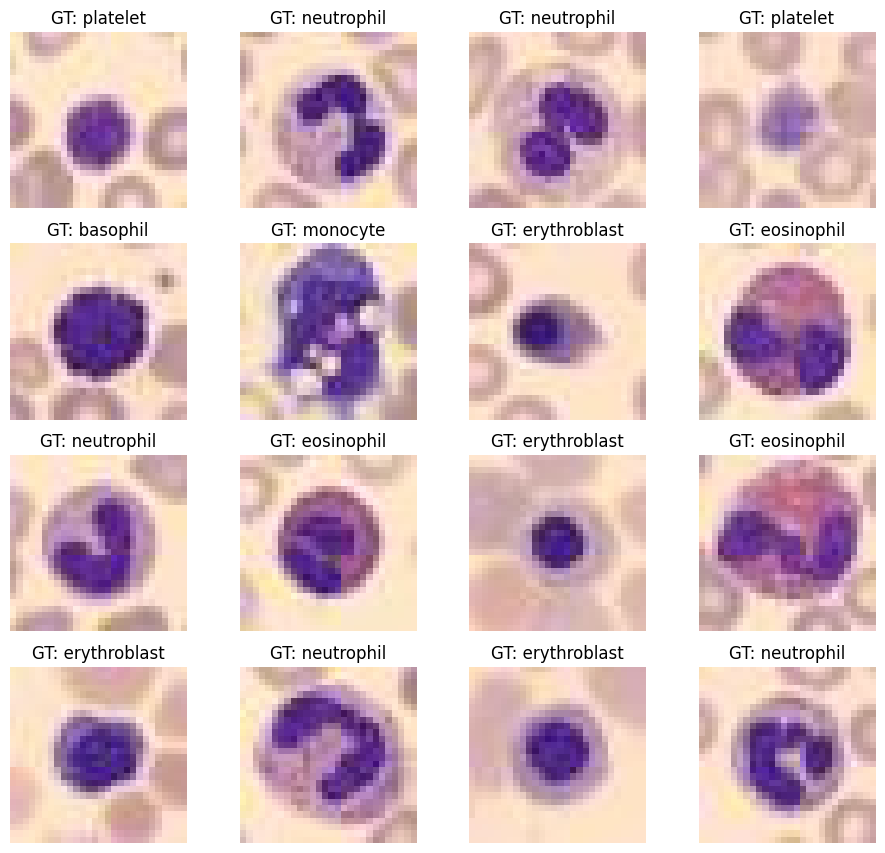

In [12]:
# encapsulate data into dataloader form
batch_size = 2048
sample_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# show some random training images
images, labels = next(iter(train_loader))
plt.figure()
for i in range(sample_size):
    fig = plt.subplot(4,4,i+1)
    plt.imshow(np.transpose((images[i]*0.5+0.5).to('cpu').numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(f'GT: {classes[str(labels[i].item())][:21]}')
    
plt.subplots_adjust(right=1.5, top=1.8)

At first, i'm going to build a DNN model based on fully connected layers, ReLU activation function and Softmax as classifier.<br>
In addition i'm using Dropout layer to prevent overfitting.<br>
The input images shape is 28x28x3, but the input of the first fully connected layer is a 1D tensor, so i flattened the image to $28*28*3 = 2352$ tensor.<br>
The ReLU activation function gives nonlinearity to add complexity to the model, and the Softmax layer outputs the classification probability for each class.

In [27]:
# building the dnn model

class DNN_Model(nn.Module):
    def __init__(self):
        super(DNN_Model, self).__init__()
        self.FC1 = nn.Linear(3*28*28,1024)
        self.RelU1 = nn.ReLU()
        self.FC2 = nn.Linear(1024, 128)
        self.RelU2 = nn.ReLU()
        self.FC3 = nn.Linear(128, 8)
        self.Dropout = nn.Dropout(0.25)
        self.Smax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 3*28*28) # flatten all dimensions except the batch dimension
        x = self.FC1(x)
        x = self.RelU1(x)
        x = self.FC2(x)
        x = self.RelU2(x)
        x = self.FC3(x)
        x = self.Dropout(x)
        x = self.Smax(x)
        return x

dnn_model = DNN_Model().to(device)
summary(dnn_model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       2,409,472
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 128]         131,200
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 8]           1,032
           Dropout-6                    [-1, 8]               0
        LogSoftmax-7                    [-1, 8]               0
Total params: 2,541,704
Trainable params: 2,541,704
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 9.70
Estimated Total Size (MB): 9.72
----------------------------------------------------------------


I trained the model for 50 epochs with initial learning rate of 0.001 and decrease it every 10 epochs.<br>
The loss function is NLLLoss - negative log likelihood loss.<br>
In the training loop i feed forward the data through the model, calculate the loss and then backprop the gradients to update the weights with the Adam optimizer.

In [28]:
# Add ClearML task
train_number += 1
task = Task.init(project_name="MedMNIST", task_name=f"DNN training {train_number}")

# train the DNN model
learning_rate = 0.001
loss_func = nn.NLLLoss()
optimizer = optim.Adam(dnn_model.parameters(), lr=learning_rate)
epochs = 50
n_total_steps = len(train_loader)
val_every = int(n_total_steps/5)
train_loss= []
train_acc = 0
train_acc_list = []
val_loss_list = []
val_acc_list = []
iterations = 0
dnn_model.train()

# update hyper parameters to ClearML
params = {
    "number_of_epochs": epochs,
    "batch_size": batch_size,
    "base_lr": learning_rate,
    "decrease lr": "by 10 every 30 epochs",
    "loss_func": "NLLLoss",
    "optimizer": optimizer.__module__
}
params = task.connect(params)

# upload model to ClearML
output_model = OutputModel(task=task)
output_model.update_labels(cml_labels)
output_model.update_design(config_dict=dnn_model.__dict__['_modules'])

# starting the training loop
for epoch in range(epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.view(-1).type(torch.int64).to(device)

        # Forward pass
        output = dnn_model(images)
        loss = loss_func(output, labels)
        
        # calculate training accuracy
        with torch.no_grad():
            equality = (output.max(dim=1)[1] == labels)
            train_acc += equality.type(torch.FloatTensor).mean()
            iterations += 1

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % val_every == 0:
            dnn_model.eval()

            # updating training loss and accuracy to clearml server
            Logger.current_logger().report_scalar("Loss", "training loss", iteration=iterations, value=loss.item())
            Logger.current_logger().report_scalar("Accuracy","training accuracy", iteration=iterations, value=train_acc/iterations)

            # calculate validation loss and accuracy
            with torch.no_grad():
                 val_loss, val_acc = validate(dnn_model, loss_func, val_loader)

            # updating validation loss and accuracy to clearml server
            Logger.current_logger().report_scalar("Loss", "val loss", iteration=iterations, value=val_loss)
            Logger.current_logger().report_scalar("Accuracy","val accuracy", iteration=iterations, value=val_acc)

            train_acc_list.append(train_acc/iterations)
            train_loss.append(loss.item())
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f}, Training Accuracy: {train_acc/iterations:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, lr = {learning_rate}')
            dnn_model.train()

    # decreasing learning rate every 10 epochs
    if (epoch+1) % 30 == 0:
        learning_rate = learning_rate/10

# close ClearML task
task.close()

print('Finished Training')

ClearML Task: created new task id=cd02a243dbd944cea07ecb15c80addf2
ClearML results page: https://app.clear.ml/projects/6406cedec9fe4554aac43d121f4ac1fe/experiments/cd02a243dbd944cea07ecb15c80addf2/output/log


Could not read Jupyter Notebook: No module named 'nbconvert'


Epoch [1/50], Step [1/6], Training Loss: 2.0669, Training Accuracy: 0.1650, Validation Loss: 1.9396, Validation Accuracy: 0.3435, lr = 0.001
Epoch [1/50], Step [2/6], Training Loss: 2.0430, Training Accuracy: 0.2275, Validation Loss: 2.0929, Validation Accuracy: 0.1822, lr = 0.001
Epoch [1/50], Step [3/6], Training Loss: 2.2524, Training Accuracy: 0.2157, Validation Loss: 1.8723, Validation Accuracy: 0.3335, lr = 0.001
Epoch [1/50], Step [4/6], Training Loss: 1.9091, Training Accuracy: 0.2312, Validation Loss: 1.7454, Validation Accuracy: 0.4796, lr = 0.001
Epoch [1/50], Step [5/6], Training Loss: 1.7941, Training Accuracy: 0.2621, Validation Loss: 1.6889, Validation Accuracy: 0.3762, lr = 0.001
Epoch [1/50], Step [6/6], Training Loss: 1.7709, Training Accuracy: 0.2725, Validation Loss: 1.6064, Validation Accuracy: 0.3931, lr = 0.001
Epoch [2/50], Step [1/6], Training Loss: 1.6831, Training Accuracy: 0.2808, Validation Loss: 1.5149, Validation Accuracy: 0.4556, lr = 0.001
Epoch [2/50],

In [29]:
# save the DNN model
path =  f'models/DNN_model.pth'
torch.save(dnn_model.state_dict(), path)

You can see in the graphs below that the model converged and there is no overfitting according to that the val loss is lower than the train loss.

Training Accuracy: 0.6917
Validation Accuracy: 0.8662
Training Loss: 0.5116
Validation Loss: 0.3906


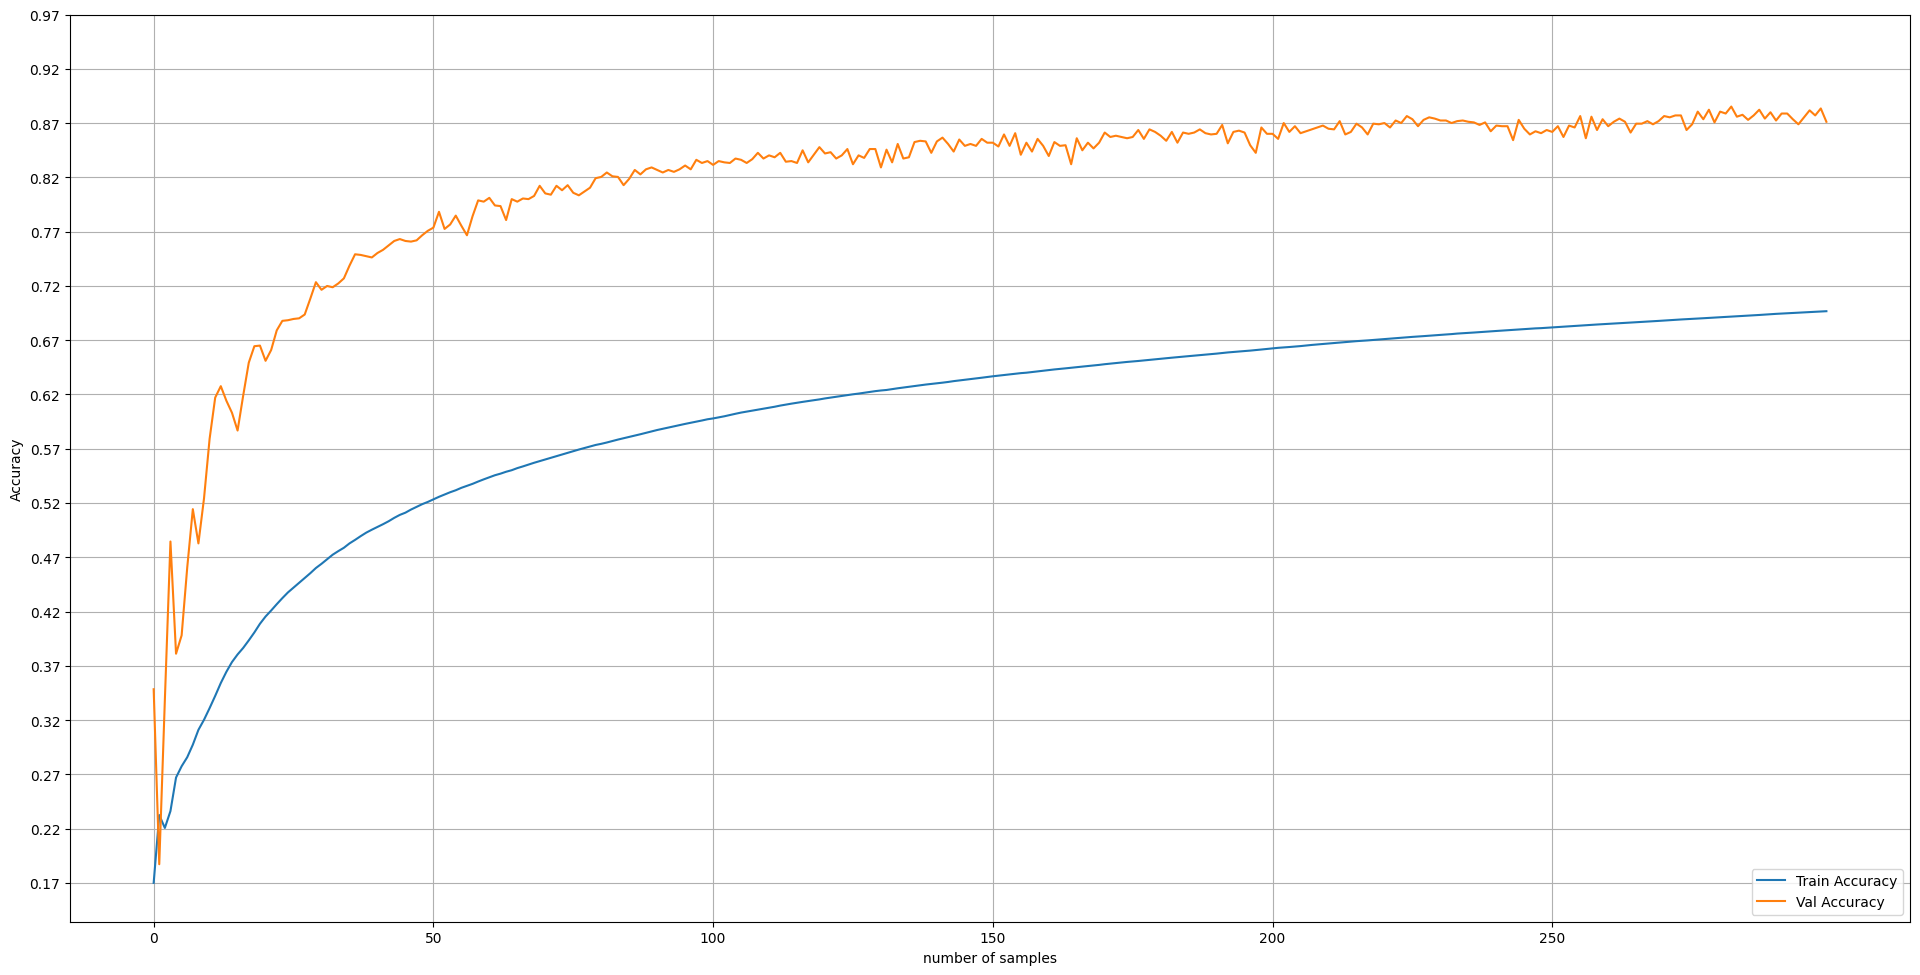

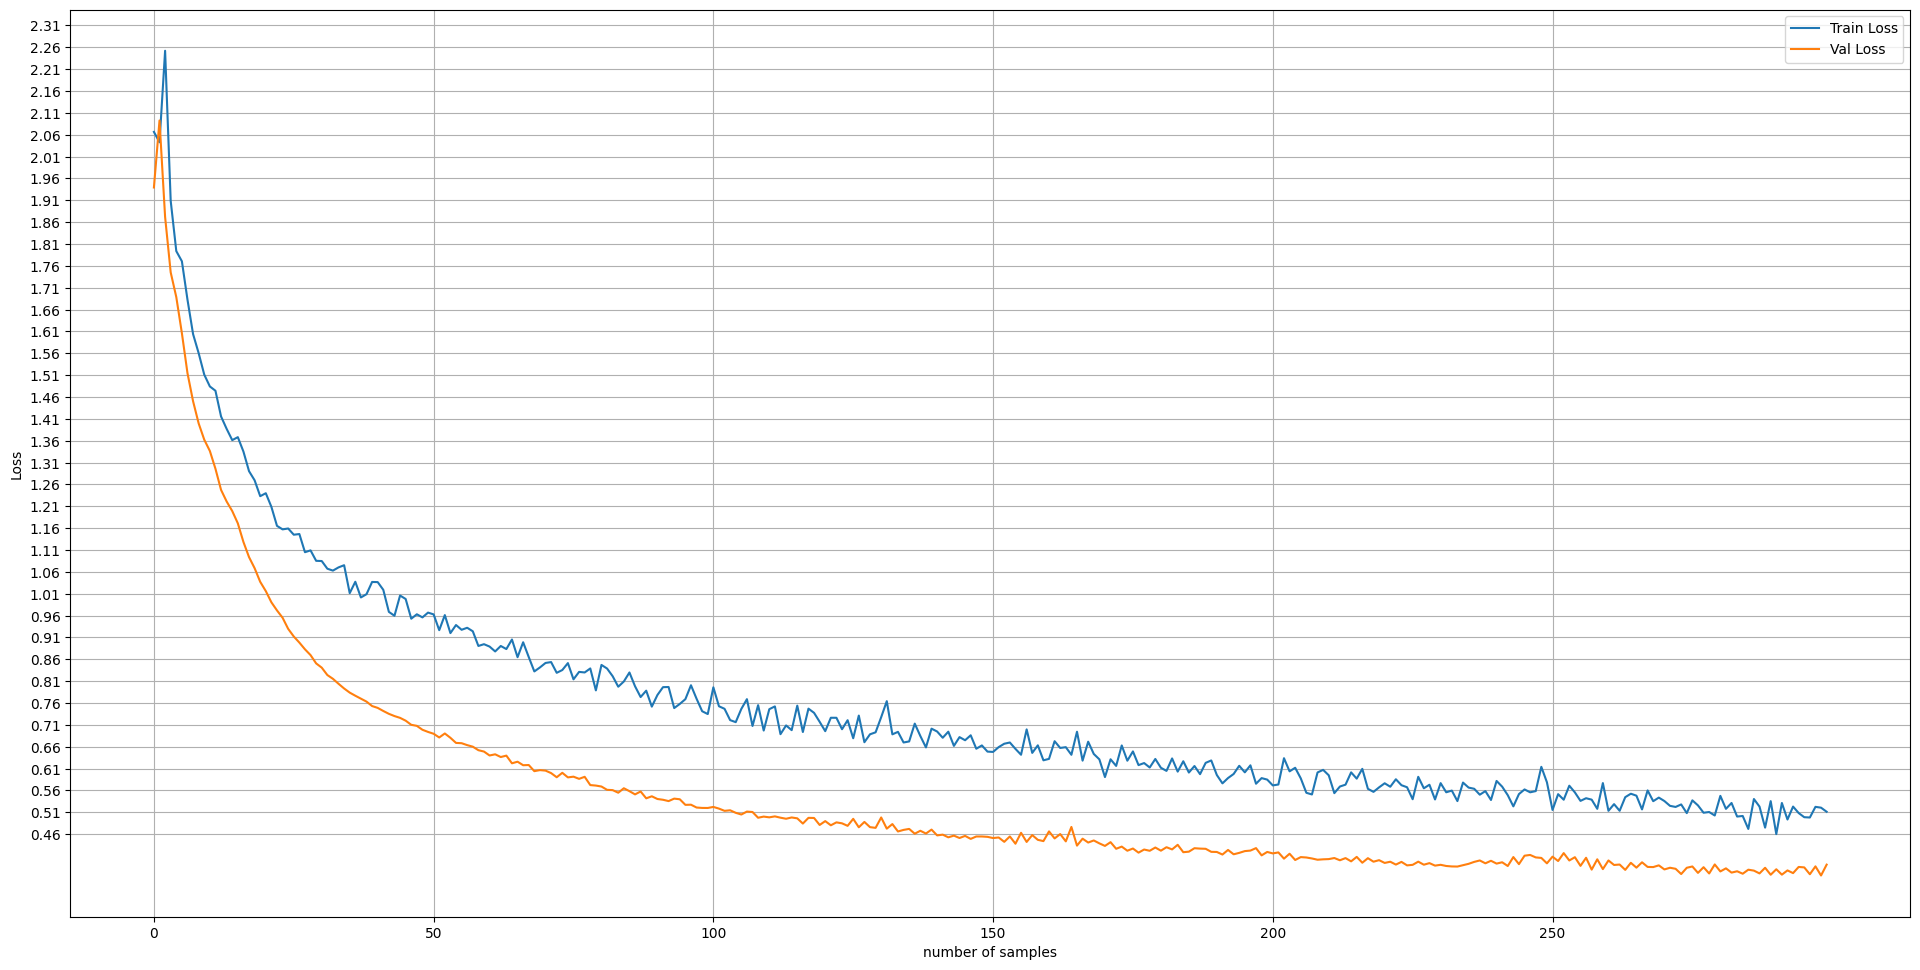

In [30]:
# display DNN Model loss and accuracy graphs
acc_graph(train_acc_list, val_acc_list)
loss_graph(train_loss, val_loss_list)

In the test section i'm presenting the following evaluating metrics: accuracy, recall, precision and confusion matrix.<br>
In addition, i'm showing examples of the data with the true and predicated class.<br><br>
Accuracy computes by: $$ Accuracy = \frac{True\;Predications}{Total\;Data}$$<br>
Recall computes by: $$ Recall = \frac{True\;Positive}{True\;Positive+False\;Positive}$$<br>
Precision computes by: $$ Precision = \frac{True\;Positive}{True\;Positive+False\;Negative}$$<br>
True Positive: the model predicted a class that correspond to the input.<br>
False Positive: the model predicted a class that is not correspond to the input.<br>
True Negative: the model didn't predicted a wrong class of the input.<br>
False Negative: the model didn't predicted the class of the input.<br><br>
Confusion Matrix shows a table of the True classes corresponding to the predicated classes.

DNN Model
Test Accuracy: 0.8571
                       precision    recall  f1-score   support

             basophil       0.81      0.62      0.71       244
           eosinophil       0.95      0.96      0.96       624
         erythroblast       0.96      0.81      0.88       311
immature granulocytes       0.63      0.87      0.73       579
           lymphocyte       0.87      0.78      0.82       243
             monocyte       0.85      0.67      0.75       284
           neutrophil       0.92      0.87      0.89       666
             platelet       0.99      1.00      0.99       470

             accuracy                           0.86      3421
            macro avg       0.87      0.82      0.84      3421
         weighted avg       0.87      0.86      0.86      3421



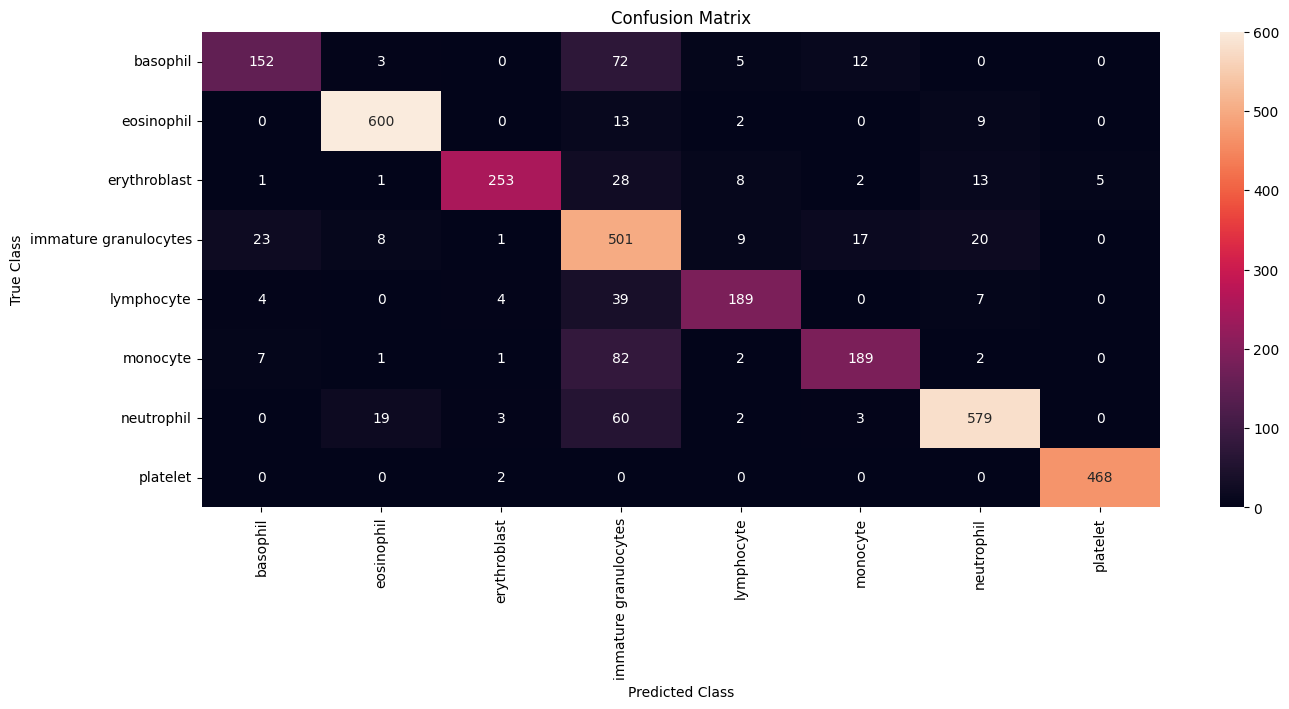

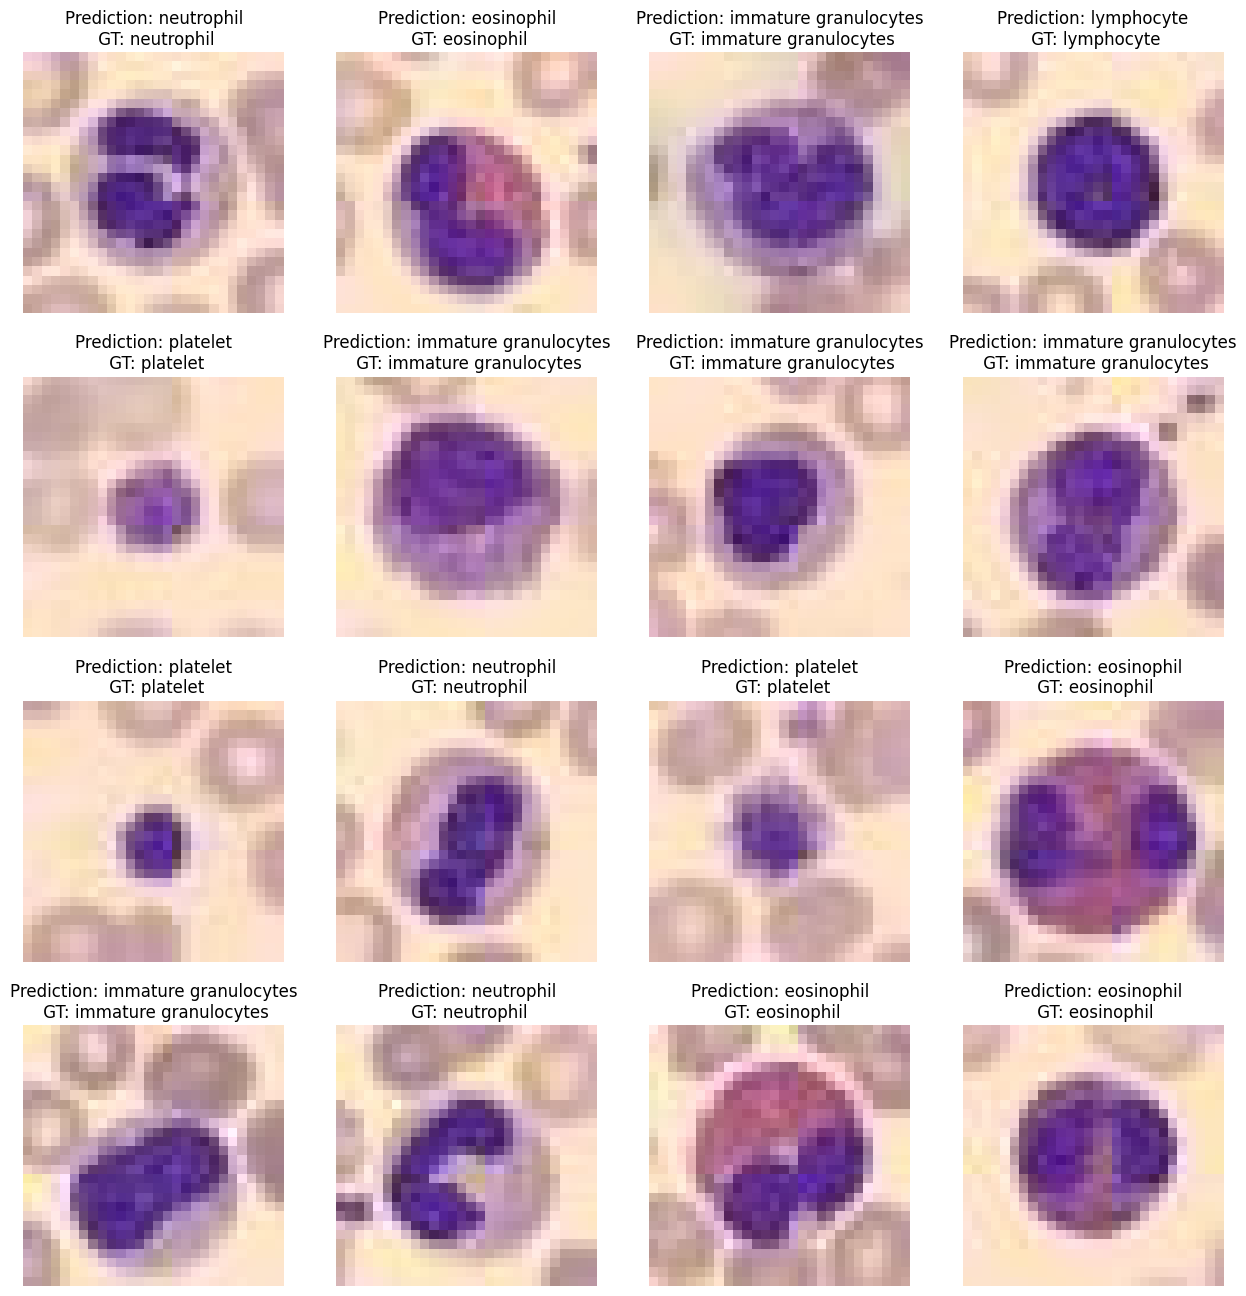

In [31]:
# test the DNN model
print("DNN Model")
test(dnn_model, test_loader, classes, batch_size, n_classes)

Now, i'm going to build a CNN model based on Convolution layers, Max Pool, fully connected layers, ReLU activation function and Softmax as classifier.<br>
In addition i'm using Dropout layer to prevent overfitting.<br>
Every convolution layer slides and multiply the input by it's filters and sums it to a pixel and outputs activation maps as the number of filters.<br>
Every convolution layer has it's number of filters, size of the filters and stride of the filters.<br>
The filters are learnable weights.<br>
The input images shape is 28x28x3, and each activation layer change the shape of the input and the number of activation maps.<br>
The purpose of the convolution layers is to extract features from the input image so the model will be able to predicts better.<br>
The Max Pooling layer decrease the dimensions of the activation maps.<br>
The input of the first fully connected layer is a 1D tensor, so i flattened the input to $264*4*4 = 4224$ tensor.<br>
The ReLU activation function gives nonlinearity to add complexity to the model, and the Softmax layer outputs the classification probability for each class.

In [32]:
# building the cnn model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.Conv1 = nn.Conv2d(3,32,3)
        self.RelU1 = nn.ReLU()

        self.Conv12 = nn.Conv2d(32,64,3)
        self.RelU12 = nn.ReLU()
        self.Maxpool1 = nn.MaxPool2d(2)

        self.Conv2 = nn.Conv2d(64,128,3)
        self.RelU2 = nn.ReLU()

        self.Conv22 = nn.Conv2d(128,256,3)
        self.RelU22 = nn.ReLU()
        self.Maxpool2 = nn.MaxPool2d(2)

        self.Fc1 = nn.Linear(256*4*4,1024)
        self.RelU3 = nn.ReLU()

        self.Fc2 = nn.Linear(1024,512)
        self.RelU4 = nn.ReLU()

        self.Fc3 = nn.Linear(512,8)
        self.Dropout2  = nn.Dropout(0.3)
        self.Smax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.Conv1(x)
        x = self.RelU1(x)
        x = self.Conv12(x)
        x = self.RelU12(x)
        x = self.Maxpool1(x)
        x = self.Conv2(x)
        x = self.RelU2(x)
        x = self.Conv22(x)
        x = self.RelU22(x)
        x = self.Maxpool2(x)
        x = x.view(-1, 256*4*4) # flatten all dimensions except the batch dimension
        x = self.Fc1(x)
        x = self.RelU3(x)
        x = self.Fc2(x)
        x = self.RelU4(x)
        x = self.Fc3(x)
        x = self.Dropout2(x)
        x = self.Smax(x)
        return x

cnn_model = CNN_Model().to(device)
summary(cnn_model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             896
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6          [-1, 128, 10, 10]          73,856
              ReLU-7          [-1, 128, 10, 10]               0
            Conv2d-8            [-1, 256, 8, 8]         295,168
              ReLU-9            [-1, 256, 8, 8]               0
        MaxPool2d-10            [-1, 256, 4, 4]               0
           Linear-11                 [-1, 1024]       4,195,328
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
             ReLU-14                  [

I trained the model for 100 epochs with a fixed learning rate of 0.001.<br>
The loss function is NLLLoss - negative log likelihood loss.<br>
In the training loop i feed forward the data through the model, calculate the loss and then backprop the gradients to update the weights with the Adam optimizer.

In [33]:
# Add ClearML task
train_number += 1
task = Task.init(project_name="MedMNIST", task_name=f"CNN training {train_number}")

# train the DNN model
learning_rate = 0.001
loss_func = nn.NLLLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
epochs = 100
n_total_steps = len(train_loader)
val_every = int(n_total_steps/5)
train_loss= []
train_acc = 0
train_acc_list = []
val_loss_list = []
val_acc_list = []
iterations = 0
cnn_model.train()

# update hyper parameters to ClearML
params = {
    "number_of_epochs": epochs,
    "batch_size": batch_size,
    "base_lr": learning_rate,
    "loss_func": "NLLLoss",
    "optimizer": optimizer.__module__
}
params = task.connect(params)

# upload model to ClearML
output_model = OutputModel(task=task)
output_model.update_labels(cml_labels)
output_model.update_design(config_dict=cnn_model.__dict__['_modules'])

# starting the training loop
for epoch in range(epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.view(-1).type(torch.int64).to(device)

        # Forward pass
        output = cnn_model(images)
        loss = loss_func(output, labels)
        
        # calculate training accuracy
        with torch.no_grad():
            equality = (output.max(dim=1)[1] == labels)
            train_acc += equality.type(torch.FloatTensor).mean()
            iterations += 1

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % val_every == 0:
            cnn_model.eval()

            # updating training loss and accuracy to clearml server
            Logger.current_logger().report_scalar("Loss", "training loss", iteration=iterations, value=loss.item())
            Logger.current_logger().report_scalar("Accuracy","training accuracy", iteration=iterations, value=train_acc/iterations)

            # calculate validation loss and accuracy
            with torch.no_grad():
                 val_loss, val_acc = validate(cnn_model, loss_func, val_loader)

            # updating validation loss and accuracy to clearml server
            Logger.current_logger().report_scalar("Loss", "val loss", iteration=iterations, value=val_loss)
            Logger.current_logger().report_scalar("Accuracy","val accuracy", iteration=iterations, value=val_acc)

            train_acc_list.append(train_acc/iterations)
            train_loss.append(loss.item())
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f}, Training Accuracy: {train_acc/iterations:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, lr = {learning_rate}')
            cnn_model.train()

# close ClearML task
task.close()

print('Finished Training')

ClearML Task: created new task id=02e266b7bee04eaea0d1e33e1cc31a8d
ClearML results page: https://app.clear.ml/projects/6406cedec9fe4554aac43d121f4ac1fe/experiments/02e266b7bee04eaea0d1e33e1cc31a8d/output/log


Could not read Jupyter Notebook: No module named 'nbconvert'


Epoch [1/100], Step [1/6], Training Loss: 2.0760, Training Accuracy: 0.1489, Validation Loss: 2.0534, Validation Accuracy: 0.1694, lr = 0.001
Epoch [1/100], Step [2/6], Training Loss: 2.0538, Training Accuracy: 0.1562, Validation Loss: 2.0031, Validation Accuracy: 0.2868, lr = 0.001
Epoch [1/100], Step [3/6], Training Loss: 2.0327, Training Accuracy: 0.1852, Validation Loss: 1.9962, Validation Accuracy: 0.1945, lr = 0.001
Epoch [1/100], Step [4/6], Training Loss: 2.0060, Training Accuracy: 0.1854, Validation Loss: 1.9592, Validation Accuracy: 0.1945, lr = 0.001
Epoch [1/100], Step [5/6], Training Loss: 1.9797, Training Accuracy: 0.1933, Validation Loss: 1.8720, Validation Accuracy: 0.3189, lr = 0.001
Epoch [1/100], Step [6/6], Training Loss: 1.8963, Training Accuracy: 0.2055, Validation Loss: 1.7103, Validation Accuracy: 0.3534, lr = 0.001
Epoch [2/100], Step [1/6], Training Loss: 1.7698, Training Accuracy: 0.2210, Validation Loss: 1.5996, Validation Accuracy: 0.4124, lr = 0.001
Epoch 

In [34]:
# save the CNN model
path =  f'models/CNN_model.pth'
torch.save(cnn_model.state_dict(), path)

You can see in the graphs below that the model converged and there is no overfitting according to that the val loss is lower than the train loss.<br>
Also, you can see that the CNN model has a better performance on the validation set. 

Training Accuracy: 0.7295
Validation Accuracy: 0.9515
Training Loss: 0.3392
Validation Loss: 0.2034


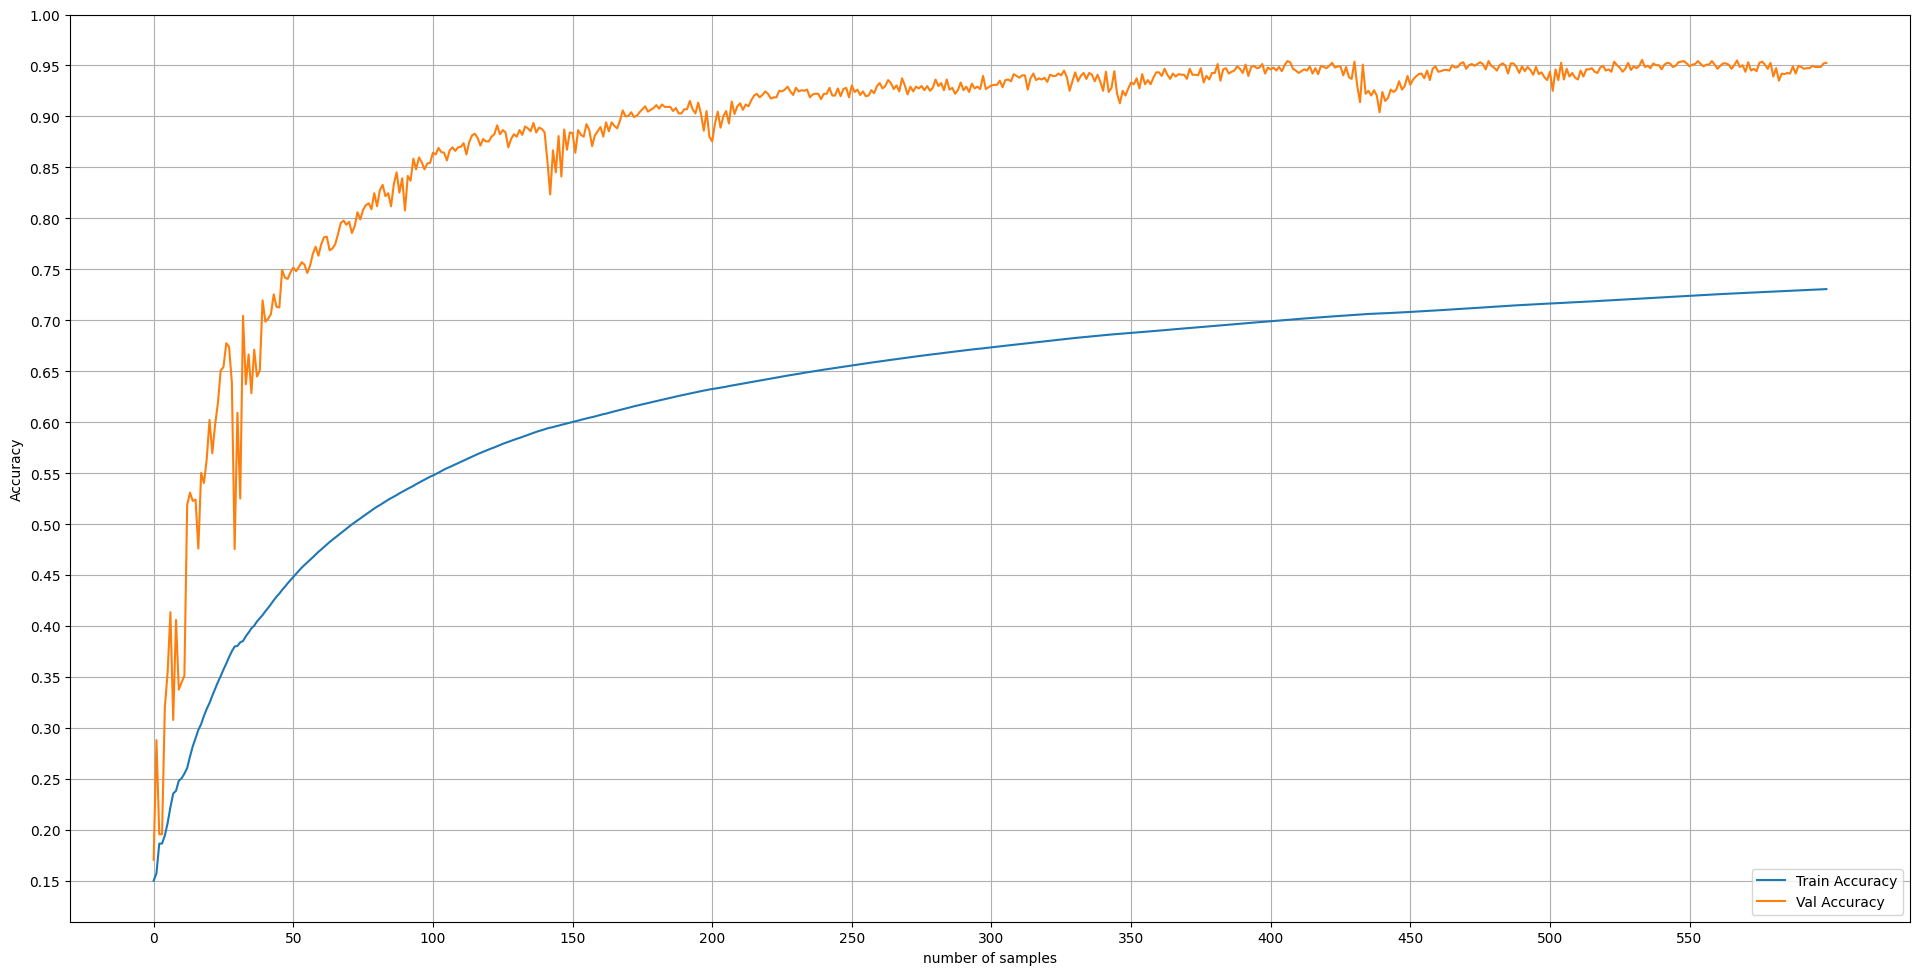

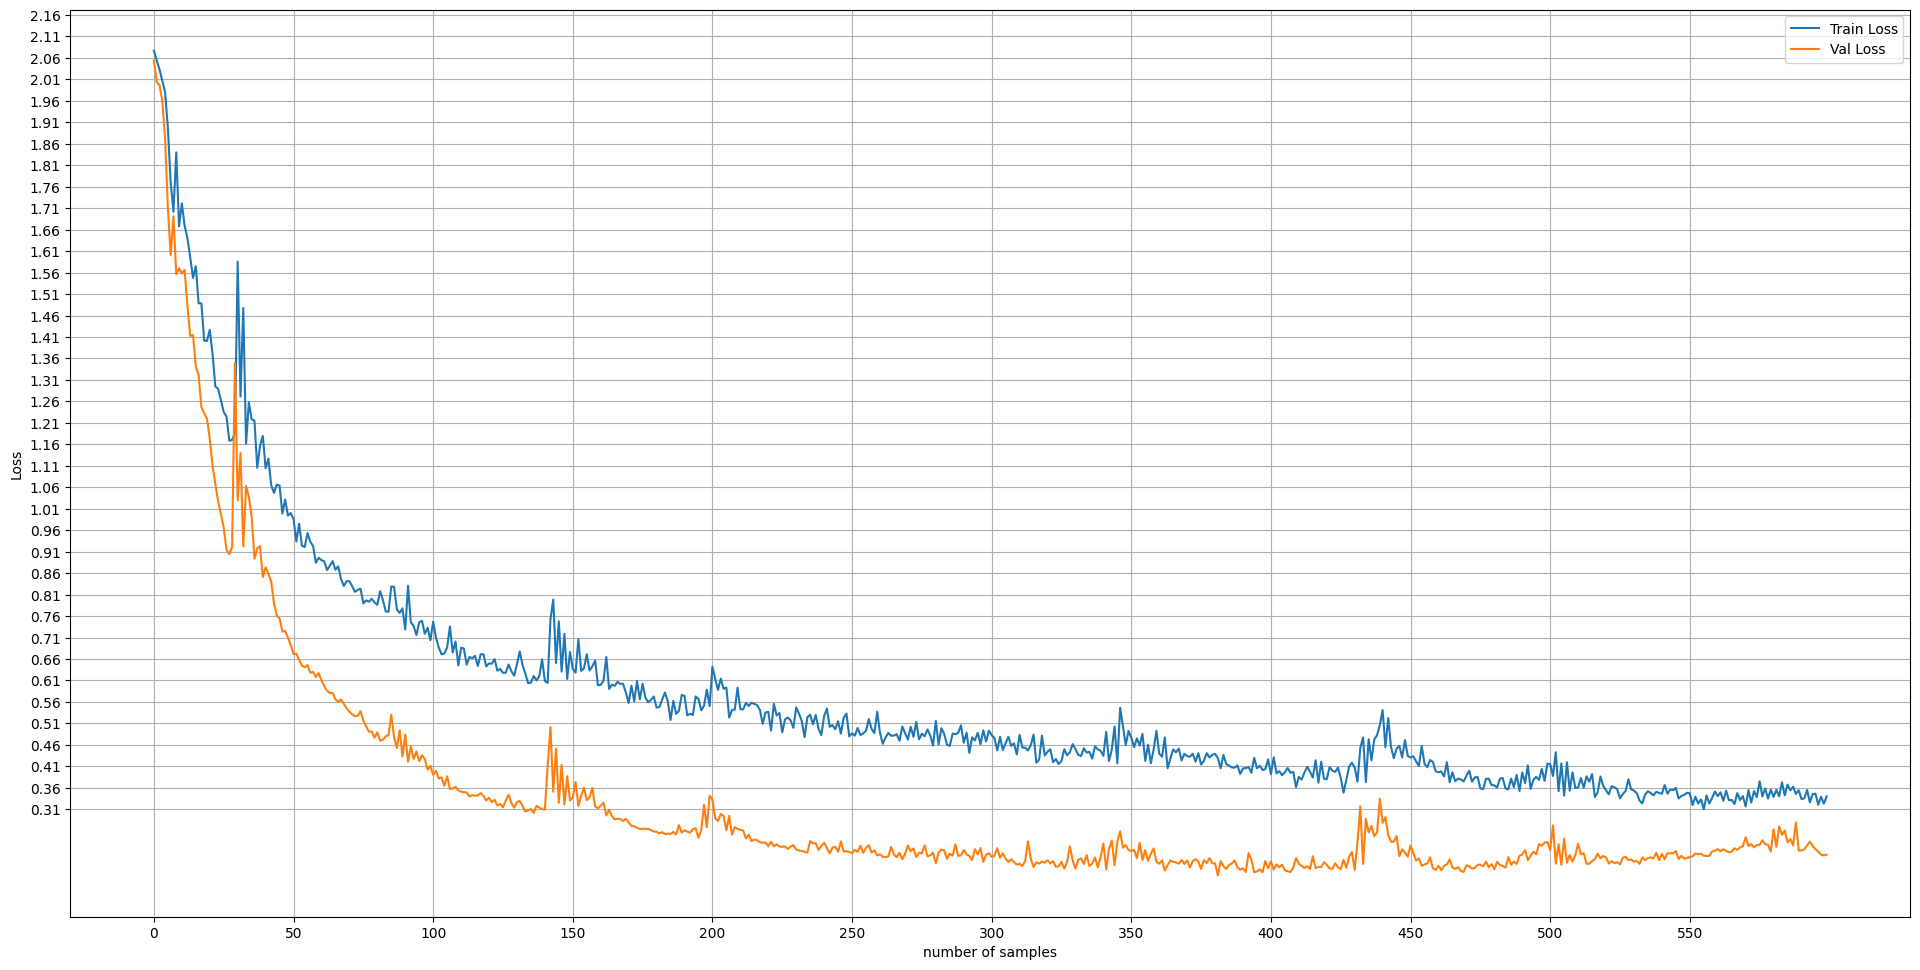

In [35]:
# display CNN Model loss and accuracy graphs
acc_graph(train_acc_list, val_acc_list)
loss_graph(train_loss, val_loss_list)

In the test section i'm presenting the following evaluating metrics: accuracy, recall, precision and confusion matrix.<br>
In addition, i'm showing examples of the data with the true and predicated class.<br><br>
Accuracy computes by: $$ Accuracy = \frac{True\;Predications}{Total\;Data}$$<br>
Recall computes by: $$ Recall = \frac{True\;Positive}{True\;Positive+False\;Positive}$$<br>
Precision computes by: $$ Precision = \frac{True\;Positive}{True\;Positive+False\;Negative}$$<br>
True Positive: the model predicted a class that correspond to the input.<br>
False Positive: the model predicted a class that is not correspond to the input.<br>
True Negative: the model didn't predicted a wrong class of the input.<br>
False Negative: the model didn't predicted the class of the input.<br><br>
Confusion Matrix shows a table of the True classes corresponding to the predicated classes.

CNN Model
Test Accuracy: 0.9463
                       precision    recall  f1-score   support

             basophil       0.90      0.85      0.87       244
           eosinophil       0.98      0.99      0.98       624
         erythroblast       0.97      0.93      0.95       311
immature granulocytes       0.89      0.88      0.88       579
           lymphocyte       0.92      0.93      0.93       243
             monocyte       0.87      0.94      0.90       284
           neutrophil       0.97      0.97      0.97       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.94      3421
            macro avg       0.94      0.94      0.94      3421
         weighted avg       0.94      0.94      0.94      3421



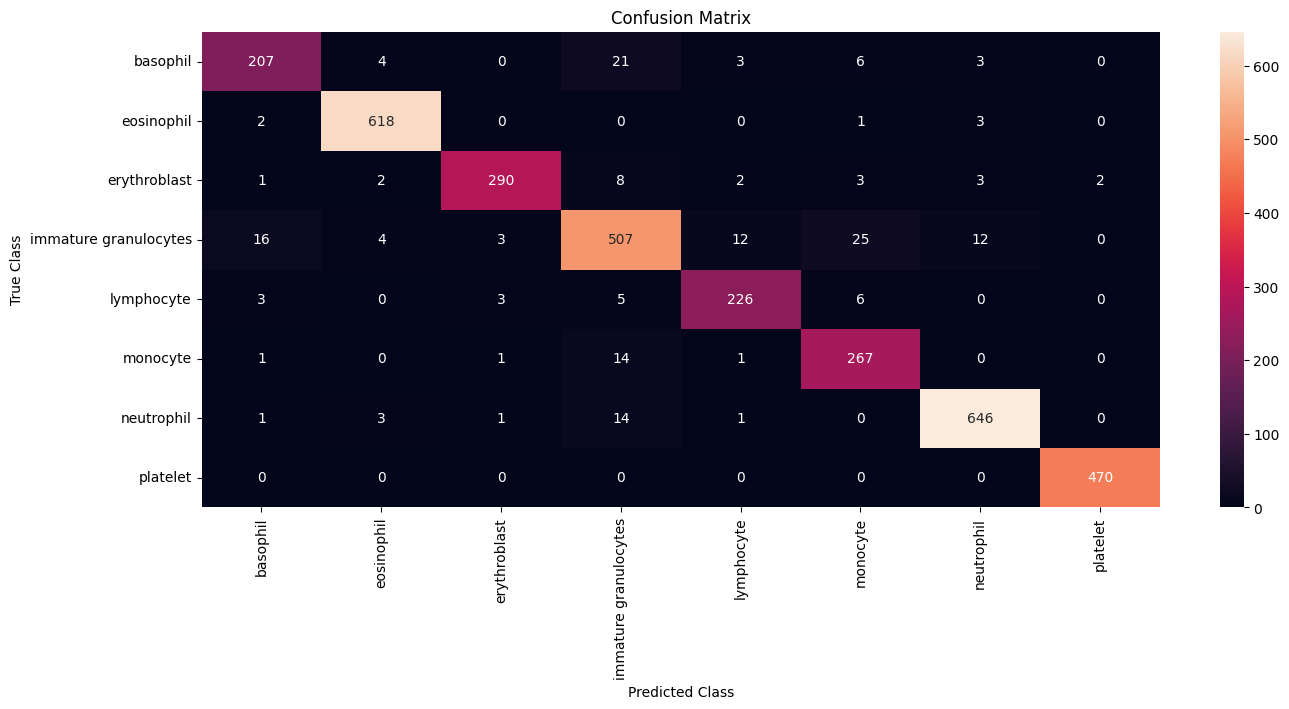

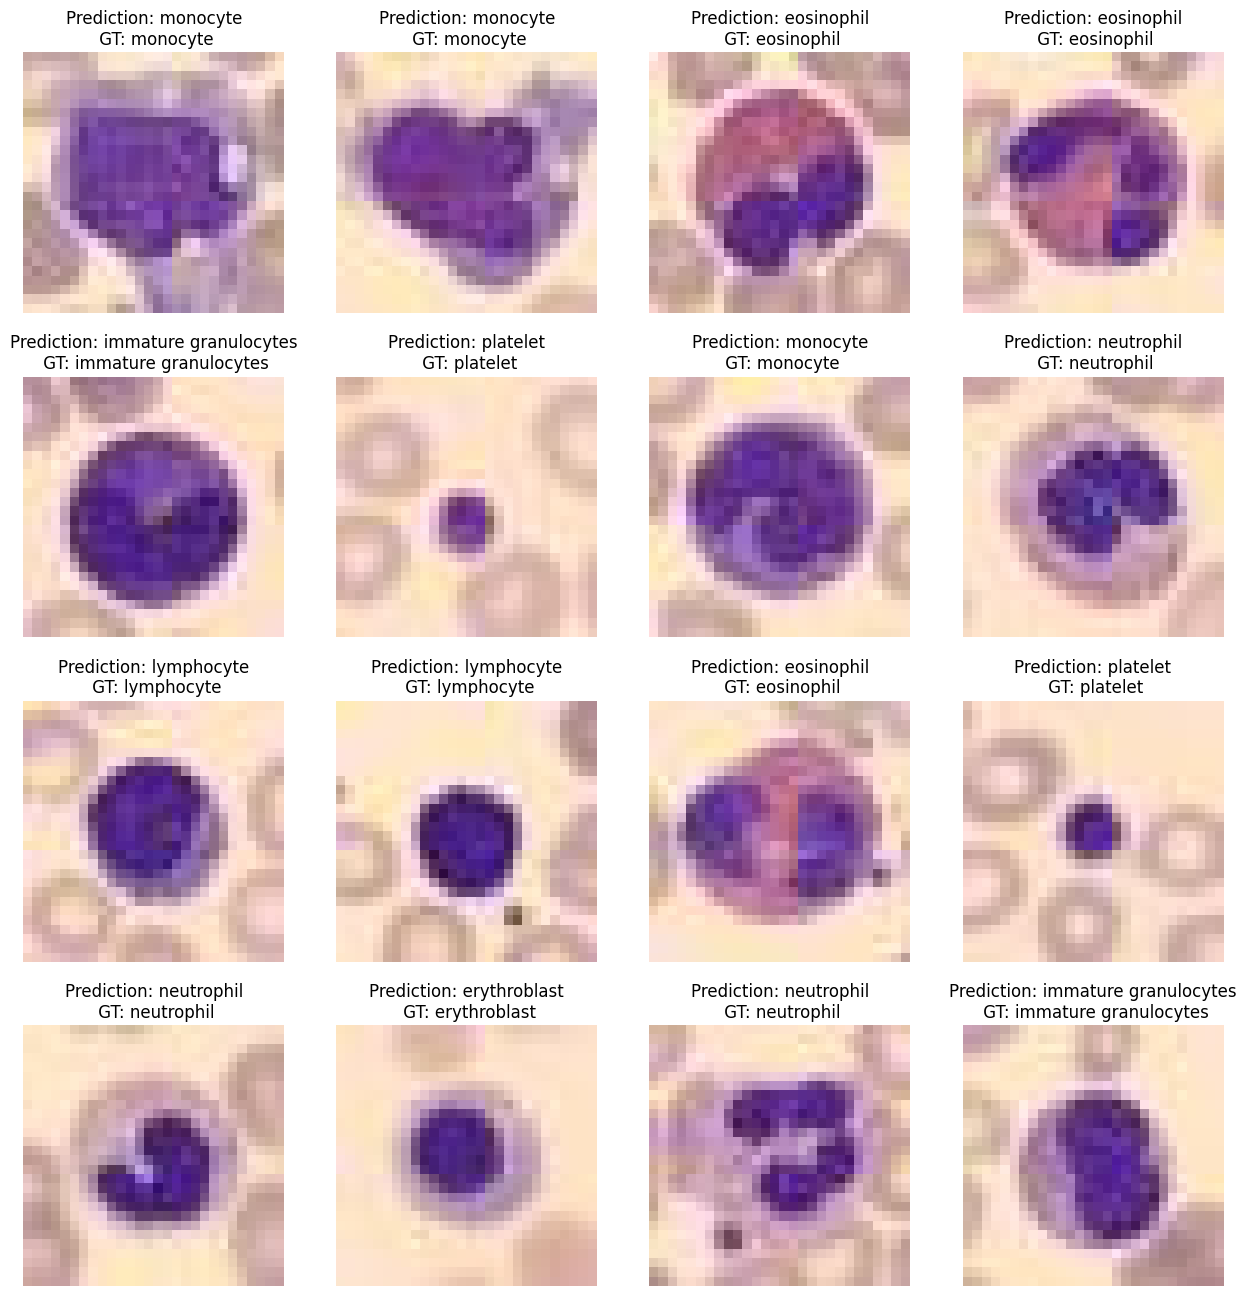

In [36]:
# test the CNN model
print("CNN Model")
test(cnn_model, test_loader, classes, batch_size, n_classes)

I chose to compare between different learning rates of 0.001 and 0.001<br>
you can see in the plots that lower learning rate slows down the training and gives smoother curve, but with higher learning rate i achieved better results faster.

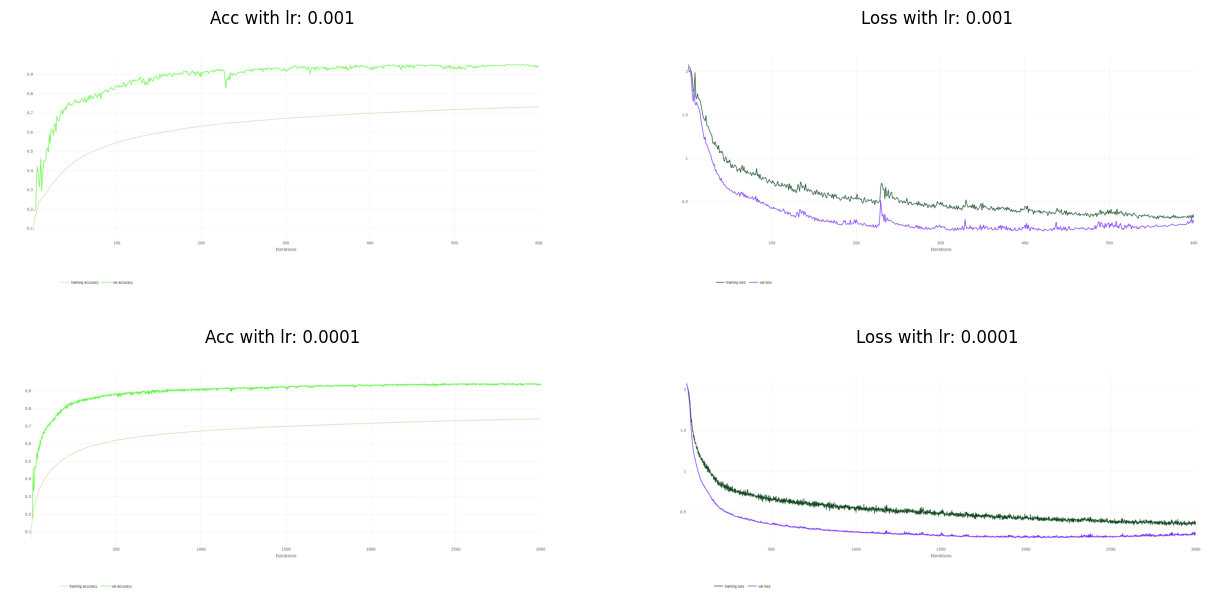

In [92]:
loss_0_001 = plt.imread('lr-0.001-loss.png')
acc_0_001 = plt.imread('lr-0.001-acc.png')
loss_0_0001 = plt.imread('lr-0.0001-loss.png')
acc_0_0001 = plt.imread('lr-0.0001-acc.png')

plt.figure()
fig = plt.subplot(2,2,1)
plt.imshow(acc_0_001)
plt.title('Acc with lr: 0.001')
plt.axis('off')

fig = plt.subplot(2,2,2)
plt.imshow(loss_0_001)
plt.title('Loss with lr: 0.001')
plt.axis('off')

fig = plt.subplot(2,2,3)
plt.imshow(acc_0_0001)
plt.title('Acc with lr: 0.0001')
plt.axis('off')

fig = plt.subplot(2,2,4)
plt.imshow(loss_0_0001)
plt.title('Loss with lr: 0.0001')
plt.axis('off')

plt.subplots_adjust(right=2, top=1.3)